# Variational Autoencoders (VAEs)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/vae

/content/drive/MyDrive/Colab Notebooks/vae


In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/vae


In [ ]:
%matplotlib inline
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

Parameter Settings
-------------------


In [ ]:
latent_dims = 2
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
#  The transformations are only applied when you load the data through the DataLoader, not directly on the dataset itself.
img_transform = transforms.Compose([transforms.ToTensor()])  # ensures the images are in the correct format (tensors with normalized/binarized pixel values)
train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## VAE

In [ ]:
# kernel_size = 4 to avoid biasing problems: https://distill.pub/2016/deconv-checkerboard/
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity # related to hidden channels you have in the AE
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1)
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

    def forward(self, x):
        # input: an image of size (b, c, s, s), c = 1, s = 28 for MNIST
        x = F.relu(self.conv1(x))         # (b, capacity, 14, 14)
        x = F.relu(self.conv2(x))         # (b, 2*capacity, 7, 7)
        x = x.view(x.size(0), -1)         # b, 2*capacity*7*7
        x_mu = self.fc_mu(x)              # b, latent_dim
        x_logvar = self.fc_logvar(x)      # b, latent_dim
        # independent latent variables is a simplification and might not capture the true structure of the data, especially if there are correlations between different latent factors.
        return x_mu, x_logvar  # latent_dim independent Gaussians, we assume the covariance matrix is diagonal

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # input: sampled latent z_tilda during training or mu during inference, size (b, latent_dim)
        x = self.fc(x)                            # (b, 2*capacity*7*7)
        x = x.view(x.size(0), capacity*2, 7, 7)   # (b, 2*capacity, 7, 7)
        x = F.relu(self.conv2(x))                 # (b, capacity, 14, 14)
        x = torch.sigmoid(self.conv1(x))          # (b, 1, 28, 28)
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        # input: images, shape (128, 1, 28, 28) -> bsize, channels, s, s
        latent_mu, latent_logvar = self.encoder(x)                  # latent gaussian distribution, shape (128, 2) -> bsize, latent_dim, Gaussian with diagonal covariance
        latent = self.latent_sample(latent_mu, latent_logvar)       # latent z follows N(mu, var), shape (128, 2) -> bsize, latent_dim
        x_recon = self.decoder(latent)                              # reconstructed image, shape(128, 1, 28, 28) -> bsize, channels, s, s
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()            # get the std
            eps = torch.empty_like(std).normal_()   # sample from N(0, std^2)
            return eps.mul(std).add_(mu)            # add mu so that it follows N(mu, std^2)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # cross entropy loss, reduction is sum, which is the direct implementation of the negative log likelihood, but mean makes the loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence


vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308357


Train VAE
--------

In [ ]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)
vae.train()
train_loss_avg = []
print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    for image_batch, _ in train_dataloader:
        image_batch = image_batch.to(device)
        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        # break
    train_loss_avg[-1] /= num_batches
    # break
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
x.shape torch.Size([128, 1, 28, 28])
latent_mu.shape, latent_logvar.shape torch.Size([128, 2]) torch.Size([128, 2])
latent.shape torch.Size([128, 2])
x_recon torch.Size([128, 1, 28, 28])


In [ ]:
#### Save the model if needed
# save_path = 'vae_model.pth'
# torch.save(vae.state_dict(), save_path)
# print(f'Model saved to {save_path}')

Model saved to vae_model.pth


In [ ]:
#### Load the model if needed
# vae = VariationalAutoencoder()
# vae.load_state_dict(torch.load('vae_model.pth'))
# vae = vae.to(device)
# print('Model loaded successfully')

<ipython-input-8-aca68d512bc1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load('vae_model.pth'))


Model loaded successfully


Plot Training Curve
--------------------

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Evaluate on the Test Set
-------------------------

In [ ]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:

    with torch.no_grad():

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 19172.250742


Visualize Reconstructions
--------------------------

Original images


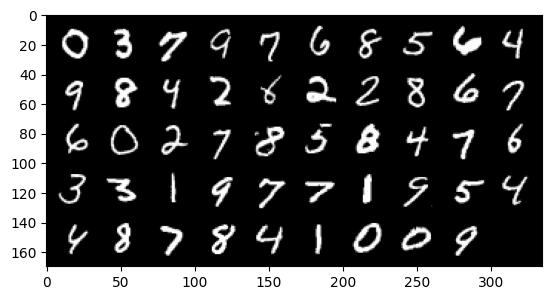

VAE reconstruction:


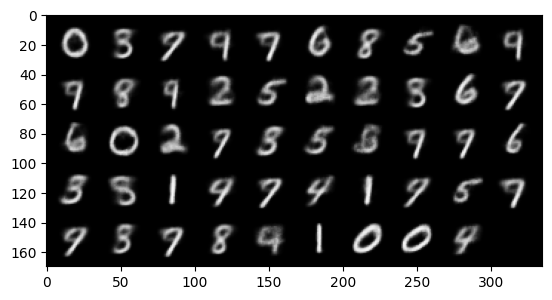

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(test_dataloader))

print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

print('VAE reconstruction:')
visualise_output(images, vae)

Interpolate in Latent Space
----------------------------

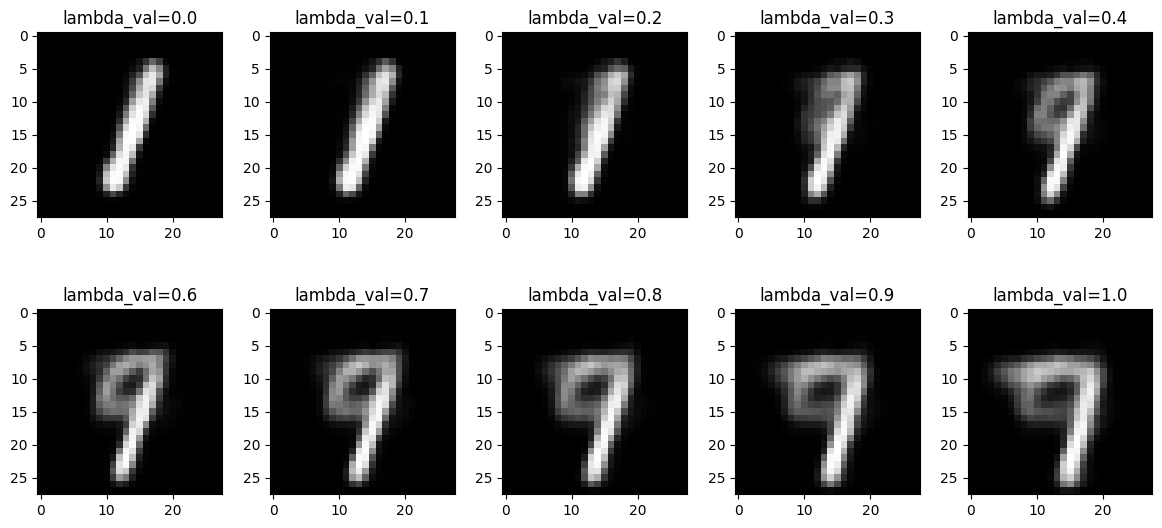

In [ ]:
vae.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])

    inter_image = to_img(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()

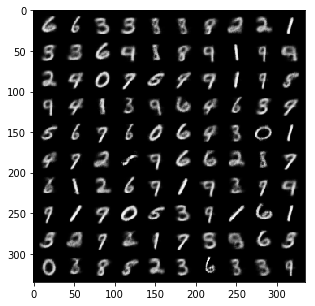

In [ ]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

Show 2D Latent Space
---------------------

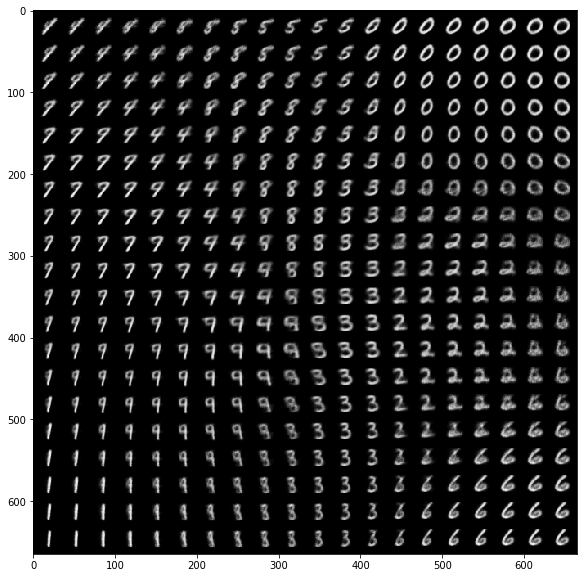

In [ ]:
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')

with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()

Note: Code adopted from https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb